In [91]:
import time
import os
import pprint
import torch
import torch.nn as nn
from sklearn.metrics import ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tqdm.notebook as tq
import utils
from pydub import AudioSegment
from tkinter import Tcl # file sorting by name
import Models, Datasets

In [16]:
def create_single_dataset(folder_path, tracks_dataframe, genre_dictionary):    
    labels = []
   
    _, file_list = get_sorted_file_paths(folder_path)
    
    for i,file in enumerate(file_list):
        #print("considering file:",file, "({}/{})".format(i,len(file_list)))
        track_id_clip_id = file.split('.')[0]
        track_id = track_id_clip_id.split('_')[0]
        #print("track id with clip: {}, track id: {}".format(track_id_clip_id, track_id))
        genre = tracks_dataframe.loc[int(track_id)]
        #print("genre from dataframe: ", genre)
        label = genre_dictionary[genre]
        #print("label from dictionary:",label)
        labels.append(label)
    print("labels length: {}".format(len(labels)))
    return labels
    

#create the train,validation and test vectors using the files in the train/validation/test folders
def create_dataset_splitted(folder_path):
    train_folder = os.path.join(folder_path,'train') # concatenate train folder to path
    validation_folder = os.path.join(folder_path,'validation') # concatenate train folder to path
    test_folder = os.path.join(folder_path,'test') # concatenate train folder to path
    
    print("train_folder:",train_folder)
    print("validation_folder:",validation_folder)
    print("test_folder:",test_folder,"\n")
    
    AUDIO_DIR = os.environ.get('AUDIO_DIR')
    print("audio directory: ",AUDIO_DIR)
    print("Loading tracks.csv...")
    tracks = utils.load('data/fma_metadata/tracks.csv')
    
    #get only the small subset of the dataset
    small = tracks[tracks['set', 'subset'] <= 'small']
    print("small dataset shape:",small.shape)    

    small_training = small.loc[small[('set', 'split')] == 'training']['track']
    small_validation = small.loc[small[('set', 'split')] == 'validation']['track']
    small_test = small.loc[small[('set', 'split')] == 'test']['track']

    print("Track.csv: {} training samples, {} validation samples, {} test samples\n".format(len(small_training), len(small_validation), len(small_test)))

    small_training_top_genres = small_training['genre_top']
    small_validation_top_genres = small_validation['genre_top']
    small_test_top_genres = small_test['genre_top']
    
    #create dictionary of genre classes:
    unique_genres = small_training_top_genres.unique()
    unique_genres = np.array(unique_genres)
    print("there are {} unique genres".format(len(unique_genres)))
    genre_dictionary = {}
    for i,genre in enumerate(unique_genres):
        genre_dictionary[genre] = i
    print("Dictionary of genres created:",genre_dictionary)
    
    
    Y_train = create_single_dataset(train_folder, small_training_top_genres, genre_dictionary)
    Y_validation = create_single_dataset(validation_folder, small_validation_top_genres, genre_dictionary)
    Y_test = create_single_dataset(test_folder, small_test_top_genres, genre_dictionary)
    
    return Y_train, Y_validation, Y_test
 
def get_sorted_file_paths(folder_path):
    file_list = os.listdir(folder_path)
    #sort the dataset files in alphabetical order (important to associate correct labels created using track_id in track.csv)
    file_list = Tcl().call('lsort', '-dict', file_list) # sort file by name: 2_0,2_1, ... 2_9,3_0, ... 400_0,400_1, ...
    file_paths = [os.path.join(folder_path, file_name) for file_name in file_list] #join filename with folder path
    #print("There are {} in the folder: {}".format(len(file_list),file_list))
    return file_paths, file_list
    
    
folder_path="data/fma_small_stft_transposed_22050_overlapped"
Y_train, Y_validation, Y_test = create_dataset_splitted(folder_path)

train_folder: data/fma_small_stft_transposed_22050_overlapped/train
validation_folder: data/fma_small_stft_transposed_22050_overlapped/validation
test_folder: data/fma_small_stft_transposed_22050_overlapped/test 

audio directory:  ./data/fma_small/
Loading tracks.csv...
small dataset shape: (8000, 52)
Track.csv: 6400 training samples, 800 validation samples, 800 test samples

there are 8 unique genres
Dictionary of genres created: {'Hip-Hop': 0, 'Pop': 1, 'Folk': 2, 'Rock': 3, 'Experimental': 4, 'International': 5, 'Electronic': 6, 'Instrumental': 7}
labels length: 128000
labels length: 16000
labels length: 16000


In [17]:
# Define the custom class for accessing our dataset
class MyDataset(Dataset):
    def __init__(self, stft_file_list,raw_file_list, labels, transform=None, verbose = False):
        self.stft_file_list = stft_file_list
        self.raw_file_list = raw_file_list
        self.labels=labels
        self.transform = transform
        self.verbose = verbose

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # returns a training sample and its label
        stft_file_path = self.stft_file_list[idx]
        raw_file_path = self.raw_file_list[idx]
        label = torch.tensor(self.labels[idx])
        stft_vector = torch.tensor(np.load(stft_file_path)) #load from file
        raw_vector=torch.tensor(np.load(raw_file_path)) 
                
        return [stft_vector,raw_vector], label

In [18]:
stft_folder_path="data/fma_small_stft_transposed_22050_overlapped"
raw_folder_path="data/fma_small_raw_array_22050_overlapped"

stft_train_folder = os.path.join(stft_folder_path,'train') # concatenate train folder to path
raw_train_folder = os.path.join(raw_folder_path,'train') # concatenate train folder to path
stft_validation_folder = os.path.join(stft_folder_path,'validation') # concatenate train folder to path
raw_validation_folder = os.path.join(raw_folder_path,'validation') # concatenate train folder to path
stft_test_folder = os.path.join(stft_folder_path,'test') # concatenate train folder to path
raw_test_folder = os.path.join(raw_folder_path,'test') # concatenate train folder to path

stft_train_file_paths, _ = get_sorted_file_paths(stft_train_folder)
raw_train_file_paths, _ = get_sorted_file_paths(raw_train_folder)
train_dataset = MyDataset(stft_train_file_paths,raw_train_file_paths, Y_train)
print("len of train dataset: ",len(train_dataset))

stft_validation_file_paths, _ = get_sorted_file_paths(stft_validation_folder)
raw_validation_file_paths, _ = get_sorted_file_paths(raw_validation_folder)
validation_dataset = MyDataset(stft_validation_file_paths,raw_validation_file_paths, Y_validation)
print("len of validation dataset: ",len(validation_dataset))

stft_test_file_paths, _ = get_sorted_file_paths(stft_test_folder)
raw_test_file_paths, _ = get_sorted_file_paths(raw_test_folder)
test_dataset = MyDataset(stft_test_file_paths,raw_test_file_paths, Y_test)
print("len of test dataset: ",len(test_dataset))

len of train dataset:  128000
len of validation dataset:  16000
len of test dataset:  16000


In [59]:
def test(model, validation_dataset, Y_validation, RGB = False, is_ensamble = False, normalized_cm = False):
    # Stop parameters learning
    model.eval()

    validation_loader = torch.utils.data.DataLoader(validation_dataset)

    criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    total_loss = 0
    confusion_matrix = np.zeros((8, 8), dtype=int)
    i=0
    
    with torch.no_grad():
        for sample, label in validation_loader:
            if(i%100==0):
                print(i,"/",(len(validation_dataset)))
            
            if(RGB==False and is_ensamble == False):
                inputs=inputs.unsqueeze(1)
                
            # Predict label
            output = model(sample[0],sample[1])
           
            
            # Compute loss
            loss = criterion(output, label)
            total_loss += loss.item()

            max_index = torch.argmax(output).item()  # The index with maximum probability

            confusion_matrix[label][max_index] += 1

            correct += (max_index == label)
            i+=1

    fig, ax = plt.subplots(dpi=500)
    if(normalized_cm == True):
        confusion_matrix = (confusion_matrix*8)/len(Y_validation)
    cm=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    cm.plot(ax=ax)
    accuracy = 100 * correct / len(Y_validation)
    average_loss = total_loss / len(Y_validation)

    model.train()
    return accuracy, average_loss, confusion_matrix

In [60]:
def vote_test(model, validation_dataset, Y_validation, RGB = False, is_ensamble = False, normalized_cm=False):
    #Stop parameters learning
    model.eval()
    
    validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=20)

    # Crea una funzione di perdita con pesi
    criterion = nn.CrossEntropyLoss()
    
    #criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    total_loss = 0
    confusion_matrix = np.zeros((8,8 ), dtype=int)

    correct_maj=0
    i = 0
    
    
    with torch.no_grad():
        for inputs, labels in validation_loader:
            if(i%100==0):
                print(i*20,"/",(len(validation_dataset)))
            #print(labels)
            
            #print("Inputs:",inputs,"size:",inputs.size())
            #print("Labels:",labels,"size:",labels.size())
            if(RGB==False and is_ensamble == False):
                inputs=inputs.unsqueeze(1)
            
            #predict label
            if(is_ensamble==True):
                outputs = model(inputs[0],inputs[1])
            else:
                output = model(inputs)
            #print("Outputs:",outputs,"size:",outputs.size())
            #compute loss
            voting=outputs.mean(dim=0)
            voting=voting.unsqueeze(0)
            label=labels[0].unsqueeze(0)
            loss = criterion(voting, label)
            total_loss += loss.item()
            #print("Voting:",voting,"size:",voting.size())
            predicted= torch.argmax(voting)
            #print("winning class",predicted)
            correct += (predicted == labels[0])
            confusion_matrix[label][predicted]+=1
            
            votes=[0,0,0,0,0,0,0,0]
            i+=1
       
            
        
    if(normalized_cm == True):
        confusion_matrix = (confusion_matrix*8)/(len(Y_validation)/20)
    cm=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    fig, ax = plt.subplots(dpi=500)
    cm.plot(ax=ax)
    cm.plot()    
    accuracy = 100*correct / (len(Y_validation)/20) 
    average_loss = total_loss / (len(Y_validation)/20)

    model.train()
    return accuracy, average_loss, confusion_matrix

In [90]:
def f1_score(confusion_matrix):
    # Calculate F1 score for each class, given a confusion matrix
    f1_scores = []
    for i in range(len(confusion_matrix)):
        true_positives = confusion_matrix[i][i]
        false_positives = sum(confusion_matrix[j][i] for j in range(len(confusion_matrix)) if j != i)
        false_negatives = sum(confusion_matrix[i][j] for j in range(len(confusion_matrix)) if j != i)

        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)

        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)

    # Calculate the average F1 score
    average_f1_score = sum(f1_scores) / len(f1_scores)

    # Print F1 scores for each class
    for i, f1 in enumerate(f1_scores):
        print(f"F1 Score for Class {i}: {f1:.4f}")

    print(f"Average F1 Score: {average_f1_score:.4f}")
    
    return average_f1_score, f1_scores

In [61]:
def train(model, dataset, batch_size, num_epochs, learning_rate, verbose = False,reg=1e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    val_loss_list=[]
    val_acc_list=[]
    train_loss_list=[]
    train_acc_list=[]
    counted_labels=[0,0,0,0,0,0,0,0]
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)
    criterion = nn.CrossEntropyLoss()

    if not isinstance(dataset, Dataset):
        raise ValueError("The dataset parameter should be an instance of torch.utils.data.Dataset.")

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    num_batches = len(data_loader)
    
    
    for epoch in range(num_epochs):
        running_loss = 0.0 
        running_accuracy = 0.0
        #initialize correctly predicted samples
        
        # Initialize the progress bar
        progress_bar = tq.tqdm(total=num_batches, unit="batch")
    
        # Initialize the progress bar description
        progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
        start_time = time.time()
        
        for batch_idx, batch in enumerate(data_loader):
            
            correct = 0 # reset train accuracy each batch
            
            inputs,labels = batch[0],batch[1]
            if(verbose == True):
                print("\ninputs shape:",inputs.size(),", dtype:",inputs.dtype," content: ",inputs)
                print("min value:",torch.min(inputs))
                print("max value:",torch.max(inputs))
                print("\nlabels shape:",labels.size(),",dtype:",labels.dtype,", content: ",labels)
          
            
            # Extract the inputs and targets
            optimizer.zero_grad()
            outputs = model(inputs[0],inputs[1])
            
            if(verbose == True):
                print("\noutputs size:",outputs.size(),"content:",outputs)
                print("List of labels until now:",counted_labels)

            loss = criterion(outputs, labels) #labels need to be a vector of class indexes (0-7) of dim (batch_size)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            #calculate train accuracy
            for index, output in enumerate(outputs):
                max_index = torch.argmax(output).item() #the index with maximum probability
                counted_labels[labels[index].item()]+=1
                if(labels[index].item() == max_index):
                    correct += 1
            
                if(verbose==True):
                    print("considering output at index {}:".format(index,output))
                    print("max output index = {}",max_index)
                    if(labels[index].item() == max_index):
                        print("correct! in fact labels[index] = {}, max_index = {}".format(labels[index].item(),max_index))
                    else:
                        print("NOT correct! in fact labels[index] = {}, max_index = {}".format(labels[index].item(),max_index))

            
            accuracy = 100 * correct / batch_size
            running_accuracy += accuracy #epoch running_accuracy
            
            # Update the progress bar description and calculate bps
            #progress_bar.set_postfix({"Loss": running_loss / (batch_idx + 1)})
            average_accuracy = running_accuracy / (batch_idx + 1)
            average_loss = running_loss / (batch_idx + 1)
            progress_bar.set_postfix({"avg_loss": average_loss, "acc": accuracy, "avg_acc": average_accuracy})

            # Update the progress bar
            progress_bar.update(1)
            # Evaluate the model on the validation dataset
        
        #calculate train loss and accuracy
        average_loss = running_loss / len(data_loader)
        average_accuracy = running_accuracy / len(data_loader)
        train_loss_list.append(average_loss)
        train_acc_list.append(average_accuracy)
        
        #calculate validation loss and accuracy
        val_acc, val_loss = test(model, validation_dataset, Y_validation)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        
        
        print(f"Epoch [{epoch+1}/{num_epochs}],Train Loss: {average_loss:.4f}. Train Accuracy: {average_accuracy} Val Loss: {val_loss} Val Accuracy: {val_acc}")
        progress_bar.close()
    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

In [41]:
class NNet1_Small(nn.Module):
    def __init__(self):
        super(NNet1_Small, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=(2, 513))
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        self.maxpool1 = nn.MaxPool2d(kernel_size=(4, 1))
        self.conv2 = nn.Conv2d(64,128, kernel_size=(2, 1))
        self.bn2 = nn.BatchNorm2d(128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(4, 1))
        self.conv3 = nn.Conv2d(128,64, kernel_size=(4, 1))
        self.bn3 = nn.BatchNorm2d(64)
        self.avgpool = nn.AvgPool2d(kernel_size=(2, 1))
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 1))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.3)
        self.dense1 = nn.Linear(256, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.dense2 = nn.Linear(128,64)
        self.bn5 = nn.BatchNorm1d(64)
        self.dense3 = nn.Linear(64, 8)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.conv1(x.float())
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x_avg = self.avgpool(x)
        x_max = self.maxpool(x)
        x = torch.cat([x_avg, x_max], dim=1)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.bn4(x)
        x = self.relu(x)
        #x = self.dense2(x)
        #x = self.dropout(x)
        #x = self.bn5(x)
        #x = self.relu(x)
        x = self.dense3(x)
        x = self.softmax(x)
        return x

In [42]:
class NNet_Raw(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(NNet_Raw, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=16)
        self.conv2 = nn.Conv1d(32, 8, kernel_size=16)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=32)
        self.maxpool1 = nn.MaxPool1d(kernel_size=8)
        self.batchnorm1 = nn.BatchNorm1d(32)
        self.batchnorm2 = nn.BatchNorm1d(8)
        self.batchnorm3 = nn.BatchNorm1d(24)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(248, 24)
        self.fc3 = nn.Linear(24, 8)
        self.softmax=nn.Softmax(dim=1)
        
    def forward(self, x):
        x=self.maxpool1(x.float())
        x = self.conv1(x)
        x = self.relu(x)
        x = self.batchnorm1(x)
        x=self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.batchnorm2(x)     
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x    

In [43]:
class Ensemble(nn.Module):
    def __init__(self, load_weights=True):
        super(Ensemble, self).__init__()

        self.raw_net=NNet_Raw()
        self.stft_net=NNet1_Small()
        if load_weights==True:
            self.raw_net.load_state_dict(torch.load("./best_models/models/NNet_Raw"), strict=False)
            self.stft_net.load_state_dict(torch.load("./best_models/models/NNet1_Small"), strict=False)

        
        self.dense1 = nn.Linear(16,16)
        self.bn = nn.BatchNorm1d(16)
        self.dense2 = nn.Linear(16, 8)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, in_stft,in_raw):
        stft=in_stft
        stft=stft.unsqueeze(1)
        #print(stft.shape)
         
        raw=in_raw
        raw=raw.unsqueeze(1)
        #print(raw.shape)
                
        x_raw=self.raw_net(raw)
        x_stft=self.stft_net(stft)
        
        x = torch.cat([x_stft, x_raw], dim=1)
        x=self.bn(x)
        x=self.dense1(x)
        #x=torch.relu(x)
        x=self.bn(x)
        x=self.dense2(x)
        x=self.softmax(x)
        
        
        return x

./results/Ensemble_No_Weights/lr_00001_reg_0001


  0%|          | 0/2000 [00:00<?, ?batch/s]

[[ 786    0  348    2  132   33  692    7]
 [  59    0  895   74  492   43  317  120]
 [   4    0 1885   22   22    6    1   60]
 [  23    0  858  692  323    6   61   37]
 [   6    0  708   21  948   11  159  147]
 [  23    0 1014   18  237  347  273   88]
 [ 155    0  565    7  415   35  682  141]
 [  18    0 1149   35  289   10   22  477]]
Epoch [1/10],Train Loss: 1.9170. Train Accuracy: 40.365625 Val Loss: 2.036887134335935 Val Accuracy: tensor([36.3563])


  0%|          | 0/2000 [00:00<?, ?batch/s]

[[ 724    0  449    0  366   14  444    3]
 [  42    0  841   40  824    8  173   72]
 [   0    0 1870   22   42    1    0   65]
 [   0    0  774  539  619    2   35   31]
 [  16    0  618    5 1198    1   43  119]
 [   5    0  994   17  415  283  202   84]
 [ 139    0  488    8  559   21  606  179]
 [  19    0 1135   17  564    3   14  248]]
Epoch [2/10],Train Loss: 1.7841. Train Accuracy: 51.5828125 Val Loss: 2.026199034020305 Val Accuracy: tensor([34.1750])


  0%|          | 0/2000 [00:00<?, ?batch/s]

KeyboardInterrupt: 

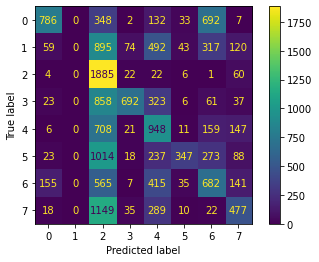

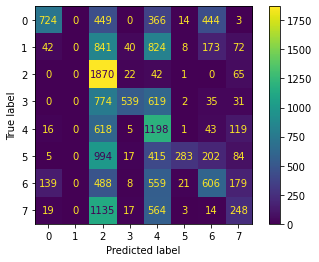

In [24]:
lr_list= [ 0.0001]
r_list=[0.001,0.0001,0.00001]
save_directory="./results/Ensemble_No_Weights/"
for i in lr_list:
    for j in r_list:
        if(j!=1e-5 and j!=1e-6):
            filename=save_directory+"lr_"+"0"+str(i).split(".")[1]+"_reg_"+"0"+str(j).split(".")[1]
        elif(j==1e-5):
            filename=save_directory+"lr_"+"0"+str(i).split(".")[1]+"_reg_"+"000001"
        else:
            filename=save_directory+"lr_"+"0"+str(i).split(".")[1]+"_reg_"+"0000001"
        print(filename)
        model = Ensemble(load_weights=False)
        train_loss_list, train_acc_list, val_loss_list, val_acc_list =train(model, train_dataset, batch_size=64, num_epochs=10, learning_rate=i, reg=j)
        print("Trained with learning rate=",i," and with regularization term=",j)
        print("Loss:",val_loss_list)
        print("Accuracy:",val_acc_list)
        save_values=[val_loss_list,val_acc_list]
        np.savetxt(filename,save_values)

In [44]:
mmodel = Ensemble()

# Define input sizes as a list of tuples or single values
input_sizes = [(128, 513), (66150,)]  # Wrap (66150,) in a tuple to make it iterable

# Summarize the model using the correct argument 'input_size'
summary(mmodel, (input_sizes))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         MaxPool1d-1              [-1, 1, 8268]               0
            Conv1d-2             [-1, 32, 8253]             544
              ReLU-3             [-1, 32, 8253]               0
       BatchNorm1d-4             [-1, 32, 8253]              64
         MaxPool1d-5             [-1, 32, 1031]               0
            Conv1d-6              [-1, 8, 1016]           4,104
              ReLU-7              [-1, 8, 1016]               0
       BatchNorm1d-8              [-1, 8, 1016]              16
         MaxPool1d-9                [-1, 8, 31]               0
           Linear-10                   [-1, 24]           5,976
             ReLU-11                   [-1, 24]               0
      BatchNorm1d-12                   [-1, 24]              48
          Dropout-13                   [-1, 24]               0
           Linear-14                   

TypeError: can't multiply sequence by non-int of type 'tuple'

In [11]:
#TODO: Add batch_size optimization loop
save_directory="./best_models/"

learning_rate_list = [0.001]
batch_size_list = [128,256,512]
reg_list=[0.00001]

for i in learning_rate_list:
    for j in reg_list:
        filename=save_directory+"results/Ensemble_No_Weights"        
        print(filename)
        model = Ensemble(load_weights=False)
        train_loss_list, train_acc_list, val_loss_list, val_acc_list =train(model, train_dataset, batch_size=64, num_epochs=10, learning_rate=i, reg=j)
        print("Trained with learning rate=",i," and with regularization term=",j)
        print("Loss:",val_loss_list)
        print("Accuracy:",val_acc_list)
        save_values=[ train_loss_list, train_acc_list, val_loss_list,val_acc_list]
        np.savetxt(filename,save_values)
        torch.save(model.state_dict(), save_directory+"models/Ensemble_No_Weights")

./best_models/results/Ensemble_No_Weights


  0%|          | 0/2000 [00:00<?, ?batch/s]

Epoch [1/10],Train Loss: 1.8283. Train Accuracy: 44.5578125 Val Loss: 1.9440723432227969 Val Accuracy: tensor([37.8312])


  0%|          | 0/2000 [00:00<?, ?batch/s]

Epoch [2/10],Train Loss: 1.7507. Train Accuracy: 51.93515625 Val Loss: 1.9540474344193934 Val Accuracy: tensor([34.9688])


  0%|          | 0/2000 [00:00<?, ?batch/s]

Epoch [3/10],Train Loss: 1.7259. Train Accuracy: 54.4625 Val Loss: 1.9105112532153725 Val Accuracy: tensor([38.6250])


  0%|          | 0/2000 [00:00<?, ?batch/s]

Epoch [4/10],Train Loss: 1.7086. Train Accuracy: 56.2578125 Val Loss: 1.907903619684279 Val Accuracy: tensor([38.3125])


  0%|          | 0/2000 [00:00<?, ?batch/s]

Epoch [5/10],Train Loss: 1.6947. Train Accuracy: 57.61953125 Val Loss: 1.877950097605586 Val Accuracy: tensor([45.1750])


  0%|          | 0/2000 [00:00<?, ?batch/s]

Epoch [6/10],Train Loss: 1.6838. Train Accuracy: 58.68046875 Val Loss: 1.8788226715028287 Val Accuracy: tensor([43.8563])


  0%|          | 0/2000 [00:00<?, ?batch/s]

Epoch [7/10],Train Loss: 1.6758. Train Accuracy: 59.49453125 Val Loss: 1.8928958126083015 Val Accuracy: tensor([40.8438])


  0%|          | 0/2000 [00:00<?, ?batch/s]

Epoch [8/10],Train Loss: 1.6719. Train Accuracy: 59.93125 Val Loss: 1.913094857133925 Val Accuracy: tensor([38.7812])


  0%|          | 0/2000 [00:00<?, ?batch/s]

Epoch [9/10],Train Loss: 1.6612. Train Accuracy: 60.98046875 Val Loss: 1.9123287193626166 Val Accuracy: tensor([38.9375])


  0%|          | 0/2000 [00:00<?, ?batch/s]

Epoch [10/10],Train Loss: 1.6598. Train Accuracy: 61.1 Val Loss: 1.8981343057081104 Val Accuracy: tensor([41.6063])
Trained with learning rate= 0.001  and with regularization term= 1e-05
Loss: [1.9440723432227969, 1.9540474344193934, 1.9105112532153725, 1.907903619684279, 1.877950097605586, 1.8788226715028287, 1.8928958126083015, 1.913094857133925, 1.9123287193626166, 1.8981343057081104]
Accuracy: [tensor([37.8312]), tensor([34.9688]), tensor([38.6250]), tensor([38.3125]), tensor([45.1750]), tensor([43.8563]), tensor([40.8438]), tensor([38.7812]), tensor([38.9375]), tensor([41.6063])]


In [12]:
#TODO: Add batch_size optimization loop
save_directory="./best_models/"

learning_rate_list = [0.0001]
reg_list=[0.00001]
epochs=7

for i in learning_rate_list:
    for j in reg_list:
        filename=save_directory+"results/Ensemble_No_Weights"        
        print(filename)
        model = Ensemble(load_weights=False)
        train_loss_list, train_acc_list, val_loss_list, val_acc_list =train(model, train_dataset, batch_size=64, num_epochs=epochs, learning_rate=i, reg=j)
        print("Trained with learning rate=",i," and with regularization term=",j)
        torch.save(model.state_dict(), save_directory+"best_models/Ensemble_No_Weights")

./best_models/results/Ensemble_No_Weights


  0%|          | 0/2000 [00:00<?, ?batch/s]

Epoch [1/7],Train Loss: 1.9121. Train Accuracy: 38.03515625 Val Loss: 2.0192161016911268 Val Accuracy: tensor([37.4188])


  0%|          | 0/2000 [00:00<?, ?batch/s]

Epoch [2/7],Train Loss: 1.8114. Train Accuracy: 47.1140625 Val Loss: 1.9953374938666821 Val Accuracy: tensor([38.5000])


  0%|          | 0/2000 [00:00<?, ?batch/s]

Epoch [3/7],Train Loss: 1.7586. Train Accuracy: 52.603125 Val Loss: 1.9759690863639117 Val Accuracy: tensor([41.9250])


  0%|          | 0/2000 [00:00<?, ?batch/s]

Epoch [4/7],Train Loss: 1.7262. Train Accuracy: 55.45859375 Val Loss: 1.9545011448562146 Val Accuracy: tensor([44.3375])


  0%|          | 0/2000 [00:00<?, ?batch/s]

Epoch [5/7],Train Loss: 1.7059. Train Accuracy: 57.2359375 Val Loss: 1.9462965673059225 Val Accuracy: tensor([43.9062])


  0%|          | 0/2000 [00:00<?, ?batch/s]

Epoch [6/7],Train Loss: 1.6920. Train Accuracy: 58.40234375 Val Loss: 1.9430950630381703 Val Accuracy: tensor([44.5750])


  0%|          | 0/2000 [00:00<?, ?batch/s]

Epoch [7/7],Train Loss: 1.6806. Train Accuracy: 59.44921875 Val Loss: 1.9371383943781257 Val Accuracy: tensor([46.0438])
Trained with learning rate= 0.0001  and with regularization term= 1e-05


In [23]:
#TODO: Add batch_size optimization loop
save_directory="./best_models/"

learning_rate_list = [0.0001]
batch_size_list = [128,256,512]
reg_list=[0.001,0.0001,0.00001]

for i in learning_rate_list:
    for j in reg_list:
        filename=save_directory+"results/Ensemble_Weights"        
        print(filename)
        model = Ensemble(load_weights=True)
        train_loss_list, train_acc_list, val_loss_list, val_acc_list =train(model, train_dataset, batch_size=64, num_epochs=10, learning_rate=i, reg=j)
        print("Trained with learning rate=",i," and with regularization term=",j)
        print("Loss:",val_loss_list)
        print("Accuracy:",val_acc_list)
        save_values=[ train_loss_list, train_acc_list, val_loss_list,val_acc_list]
        np.savetxt(filename,save_values)
        torch.save(model.state_dict(), save_directory+"models/Ensemble_Weights")

./best_models/results/Ensemble_Weights


  0%|          | 0/2000 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [15]:
#TODO: Add batch_size optimization loop
save_directory="./best_models/"

learning_rate_list = [0.0001]
reg_list=[0.00001]
epochs=4

for i in learning_rate_list:
    for j in reg_list:
        filename=save_directory+"results/Ensemble_Weights"        
        print(filename)
        model = Ensemble(load_weights=True)
        train_loss_list, train_acc_list, val_loss_list, val_acc_list =train(model, train_dataset, batch_size=64, num_epochs=epochs, learning_rate=i, reg=j)
        print("Trained with learning rate=",i," and with regularization term=",j)
        torch.save(model.state_dict(), save_directory+"best_models/Ensemble_Weights")

./best_models/results/Ensemble_Weights


  0%|          | 0/2000 [00:00<?, ?batch/s]

Epoch [1/4],Train Loss: 1.8096. Train Accuracy: 56.18984375 Val Loss: 1.8419262349456549 Val Accuracy: tensor([47.2625])


  0%|          | 0/2000 [00:00<?, ?batch/s]

Epoch [2/4],Train Loss: 1.6075. Train Accuracy: 68.62734375 Val Loss: 1.79993777410686 Val Accuracy: tensor([48.7687])


  0%|          | 0/2000 [00:00<?, ?batch/s]

Epoch [3/4],Train Loss: 1.5873. Train Accuracy: 69.0609375 Val Loss: 1.7852480294927955 Val Accuracy: tensor([49.6562])


  0%|          | 0/2000 [00:00<?, ?batch/s]

Epoch [4/4],Train Loss: 1.5839. Train Accuracy: 69.04765625 Val Loss: 1.7830202257931231 Val Accuracy: tensor([49.3688])
Trained with learning rate= 0.0001  and with regularization term= 1e-05


Model loaded: testing...
0 / 16000
2000 / 16000
4000 / 16000
6000 / 16000
8000 / 16000
10000 / 16000
12000 / 16000
14000 / 16000


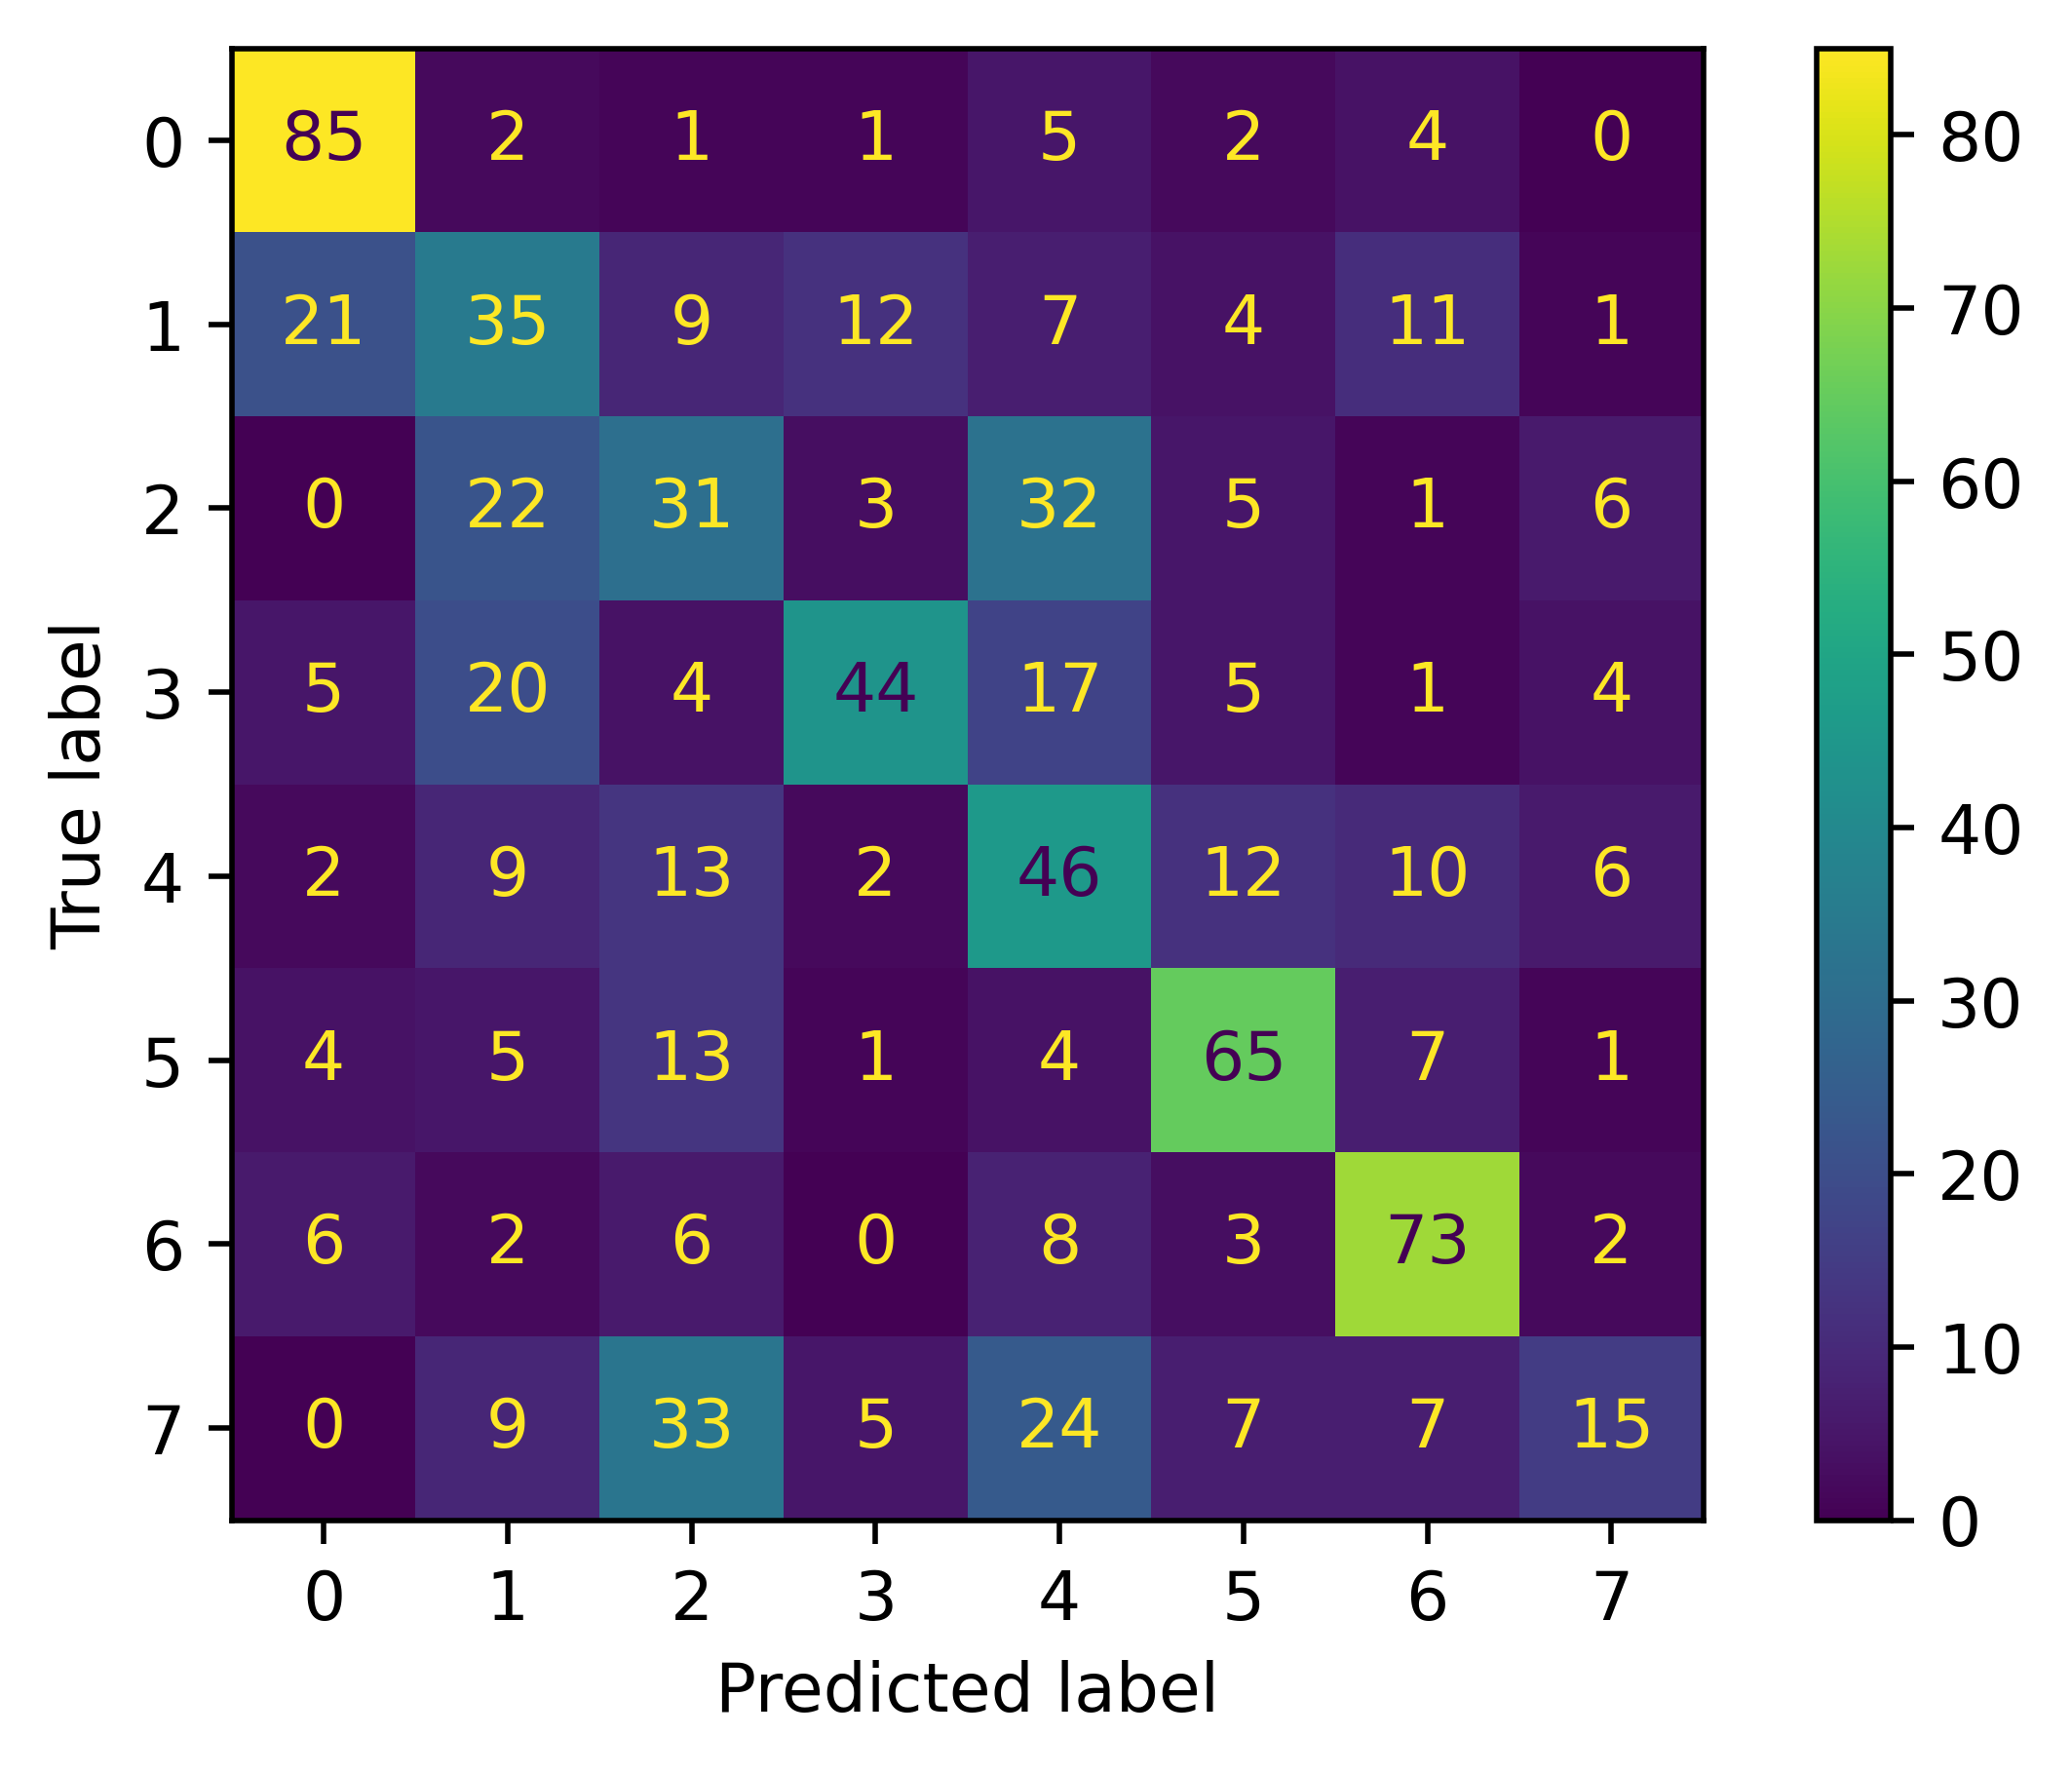

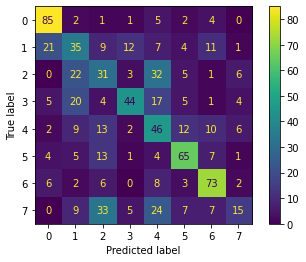

In [62]:
model_path="./best_models/best_models/"
model_name="Ensemble_Weights"

test_model=Ensemble(load_weights=True)
test_model.load_state_dict(torch.load(model_path+model_name), strict=False)
print("Model loaded: testing...")
test_results = vote_test(test_model,test_dataset, Y_test, RGB=False, is_ensamble=True, normalized_cm=False)


In [78]:
confusion_matrix = test_results[2]
print("confusion matrix for Ensemble using weights:\n",confusion_matrix)

# Define your confusion matrix
confusion_matrix = np.array(confusion_matrix)

f1_average_score, f1_scores = f1_score(confusion_matrix)

confusion matrix for Ensemble using weights:
 [[85  2  1  1  5  2  4  0]
 [21 35  9 12  7  4 11  1]
 [ 0 22 31  3 32  5  1  6]
 [ 5 20  4 44 17  5  1  4]
 [ 2  9 13  2 46 12 10  6]
 [ 4  5 13  1  4 65  7  1]
 [ 6  2  6  0  8  3 73  2]
 [ 0  9 33  5 24  7  7 15]]
F1 Score for Class 1: 0.7623
F1 Score for Class 2: 0.3431
F1 Score for Class 3: 0.2952
F1 Score for Class 4: 0.5238
F1 Score for Class 5: 0.3786
F1 Score for Class 6: 0.6404
F1 Score for Class 7: 0.6822
F1 Score for Class 8: 0.2222
Average F1 Score: 0.4810


Model loaded: testing...
0 / 16000
2000 / 16000
4000 / 16000
6000 / 16000
8000 / 16000
10000 / 16000
12000 / 16000
14000 / 16000


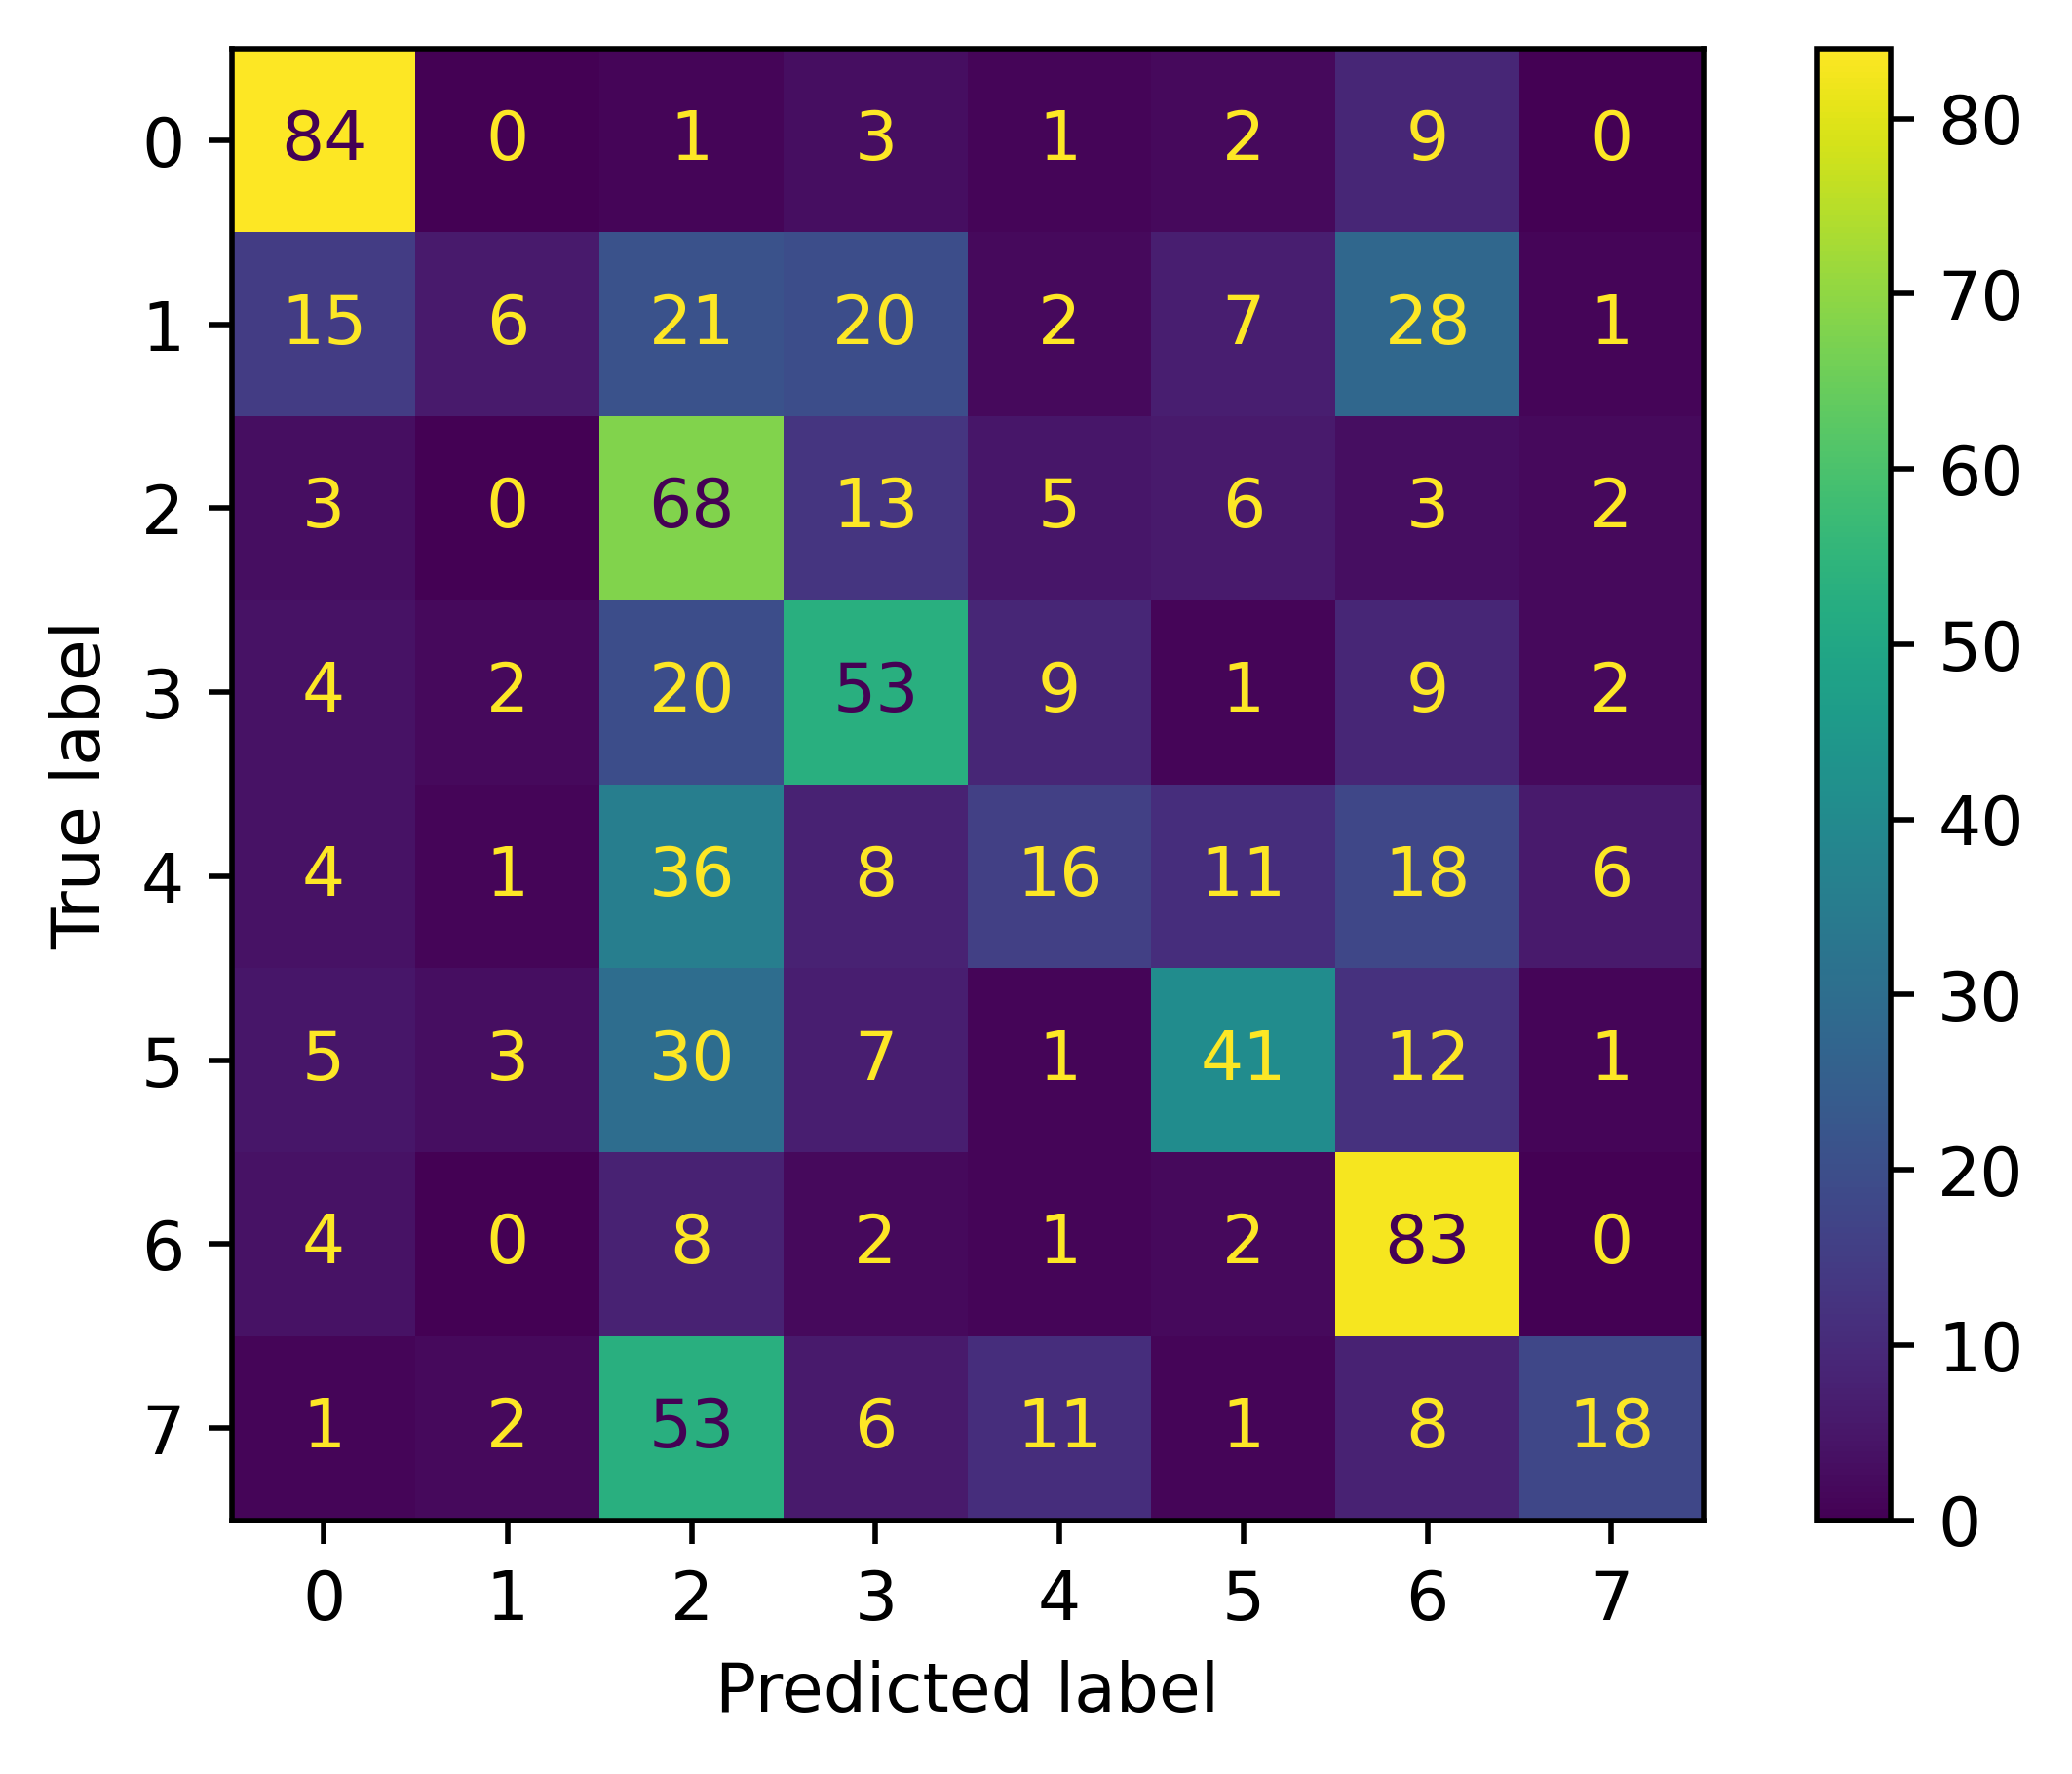

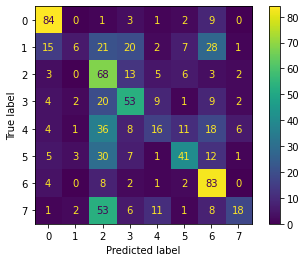

In [83]:
model_path="./best_models/best_models/"
model_name="Ensemble_No_Weights"

test_model=Ensemble(load_weights=False)
test_model.load_state_dict(torch.load(model_path+model_name), strict=False)
print("Model loaded: testing...")
test_results = vote_test(test_model,test_dataset, Y_test, RGB=False, is_ensamble=True, normalized_cm=False)


In [84]:
confusion_matrix_no_weights = test_results[2]
print("confusion matrix for Ensemble without using weights:\n",confusion_matrix_no_weights)

# Define your confusion matrix
confusion_matrix_no_weights = np.array(confusion_matrix_no_weights)

f1_average_score, f1_scores = f1_score(confusion_matrix_no_weights)

confusion matrix for Ensemble without using weights:
 [[84  0  1  3  1  2  9  0]
 [15  6 21 20  2  7 28  1]
 [ 3  0 68 13  5  6  3  2]
 [ 4  2 20 53  9  1  9  2]
 [ 4  1 36  8 16 11 18  6]
 [ 5  3 30  7  1 41 12  1]
 [ 4  0  8  2  1  2 83  0]
 [ 1  2 53  6 11  1  8 18]]
F1 Score for Class 1: 0.7636
F1 Score for Class 2: 0.1053
F1 Score for Class 3: 0.4036
F1 Score for Class 4: 0.5000
F1 Score for Class 5: 0.2192
F1 Score for Class 6: 0.4795
F1 Score for Class 7: 0.6148
F1 Score for Class 8: 0.2769
Average F1 Score: 0.4204


In [98]:
#f1 score for ResNet18_Reduced_FineTuning

confusion_matrix_res_net = [
    [81,4,0,0,2,2,7,4],
    [17,27,6,7,6,13,18],
    [1,15,28,9,24,15,0,8],
    [3,12,2,51,15,4,7,6],
    [1,4,11,4,38,5,14,23],
    [6,4,20,1,2,57,10,0],
    [4,2,3,2,4,0,78,7],
    [1,6,17,1,22,6,4,43]
]

print("confusion matrix for ResNet18 using fine tuning:\n",confusion_matrix_res_net)

# Define your confusion matrix
confusion_matrix_no_weights = np.array(confusion_matrix_no_weights)

f1_average_score, f1_scores = f1_score(confusion_matrix_no_weights)

confusion matrix for ResNet18 using fine tuning:
 [[81, 4, 0, 0, 2, 2, 7, 4], [17, 27, 6, 7, 6, 13, 18], [1, 15, 28, 9, 24, 15, 0, 8], [3, 12, 2, 51, 15, 4, 7, 6], [1, 4, 11, 4, 38, 5, 14, 23], [6, 4, 20, 1, 2, 57, 10, 0], [4, 2, 3, 2, 4, 0, 78, 7], [1, 6, 17, 1, 22, 6, 4, 43]]
F1 Score for Class 0: 0.7636
F1 Score for Class 1: 0.1053
F1 Score for Class 2: 0.4036
F1 Score for Class 3: 0.5000
F1 Score for Class 4: 0.2192
F1 Score for Class 5: 0.4795
F1 Score for Class 6: 0.6148
F1 Score for Class 7: 0.2769
Average F1 Score: 0.4204


In [99]:
#f1 score for NNet1_Small

confusion_matrix_nnet1_small = [
    [84,3,1,0,2,3,7,0],
    [19,25,6,10,6,16,18,0],
    [0,24,39,2,12,14,2,7],
    [5,21,8,41,13,7,2,3],
    [3,6,15,4,32,20,13,7],
    [4,9,10,1,1,62,12,1],
    [5,3,7,2,3,4,75,1],
    [1,6,34,5,13,10,11,20]
]

print("confusion matrix for NNet1_Small:\n",confusion_matrix_nnet1_small)

# Define your confusion matrix
confusion_matrix_nnet1_small = np.array(confusion_matrix_nnet1_small)

f1_average_score, f1_scores = f1_score(confusion_matrix_nnet1_small)

confusion matrix for NNet1_Small:
 [[84, 3, 1, 0, 2, 3, 7, 0], [19, 25, 6, 10, 6, 16, 18, 0], [0, 24, 39, 2, 12, 14, 2, 7], [5, 21, 8, 41, 13, 7, 2, 3], [3, 6, 15, 4, 32, 20, 13, 7], [4, 9, 10, 1, 1, 62, 12, 1], [5, 3, 7, 2, 3, 4, 75, 1], [1, 6, 34, 5, 13, 10, 11, 20]]
F1 Score for Class 0: 0.7602
F1 Score for Class 1: 0.2538
F1 Score for Class 2: 0.3545
F1 Score for Class 3: 0.4970
F1 Score for Class 4: 0.3516
F1 Score for Class 5: 0.5254
F1 Score for Class 6: 0.6250
F1 Score for Class 7: 0.2878
Average F1 Score: 0.4569
